In [87]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import statistics as sts
import lmfit
from lmfit import Model
from scipy.stats import sem

#Functions

# Linear Fit
def line(x, m, b):
    return x * m + b
gmodel = Model(line)
param = gmodel.make_params(m = 1, b = 1)
param['m'].set(min = 0)


C:\Users\lopezb41\AppData\Local\Temp\ipykernel_21272\436523513.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(facecolor = 'white')


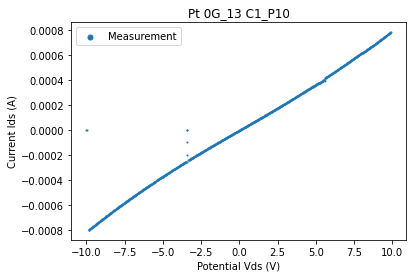

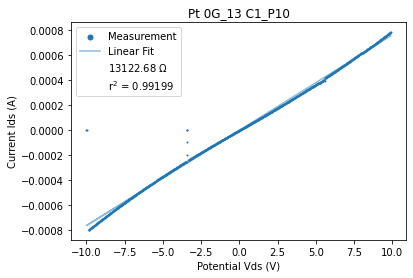

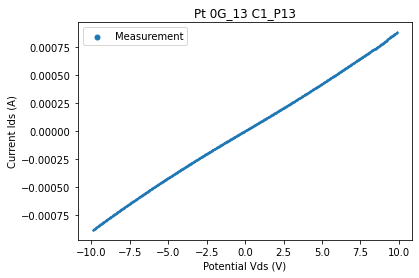

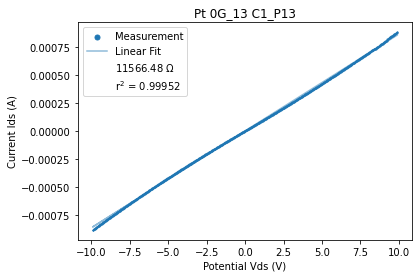

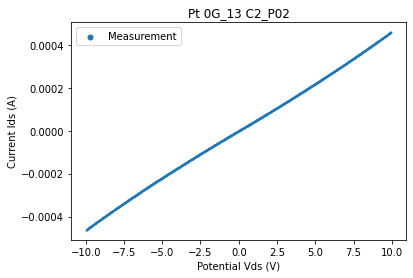

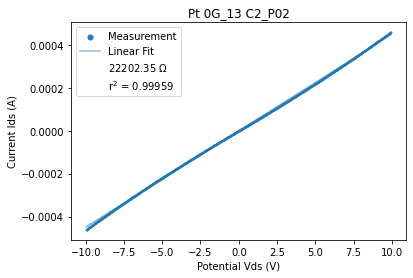

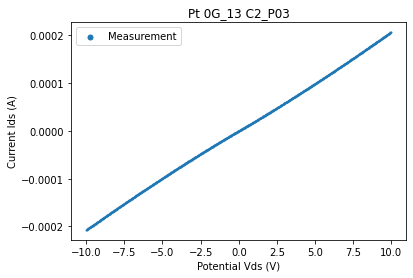

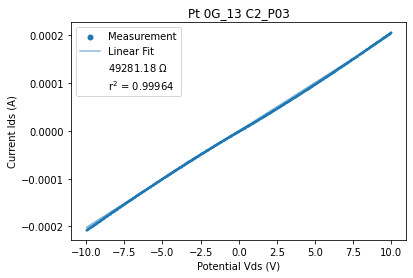

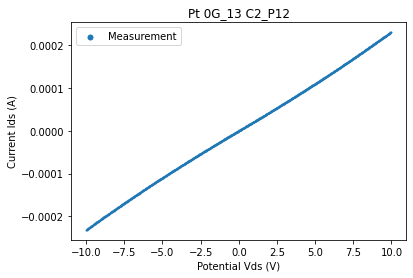

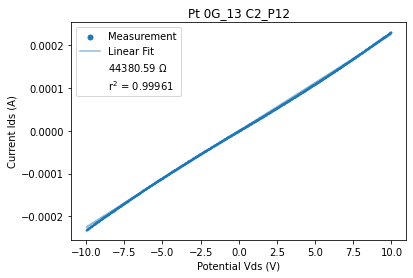

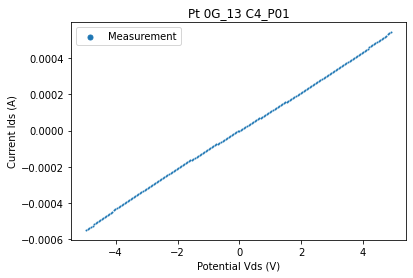

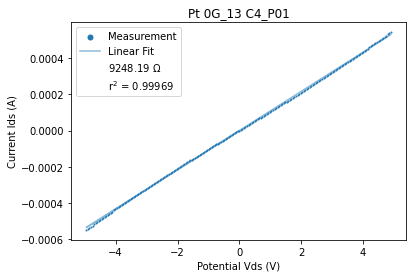

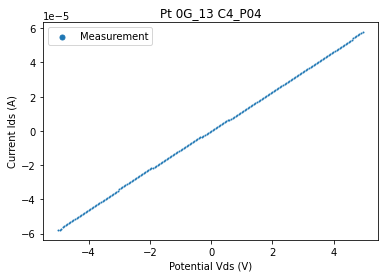

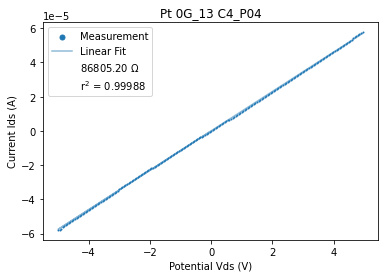

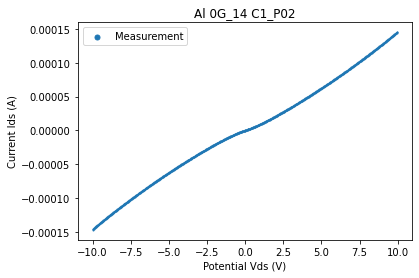

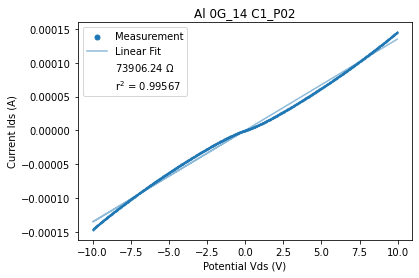

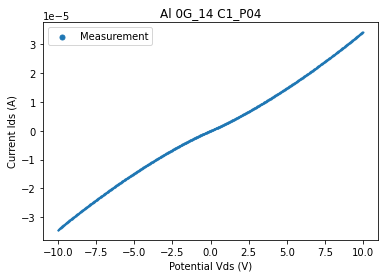

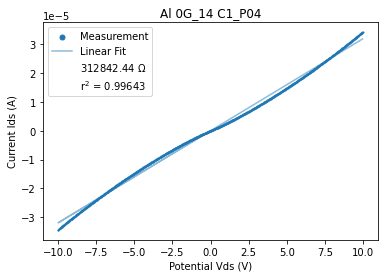

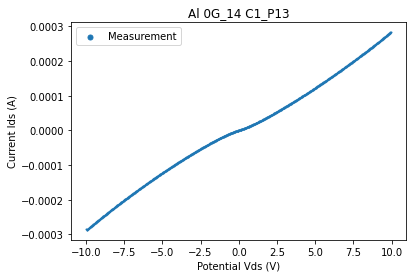

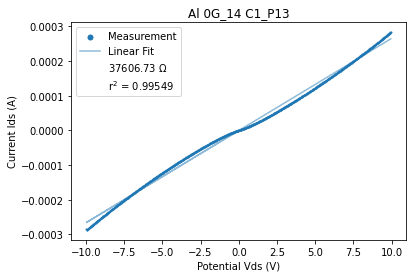

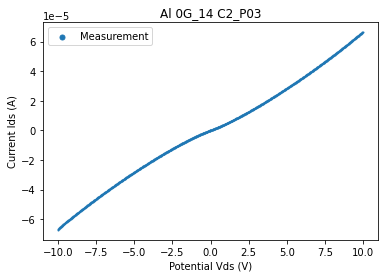

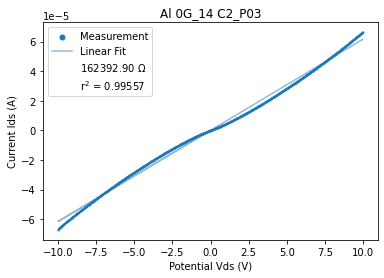

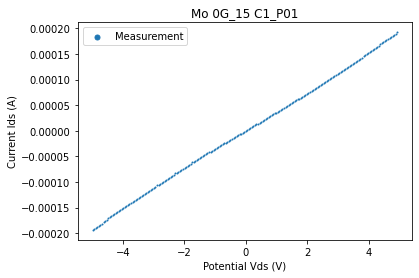

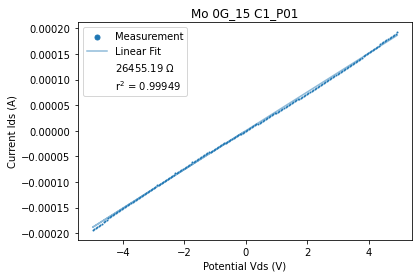

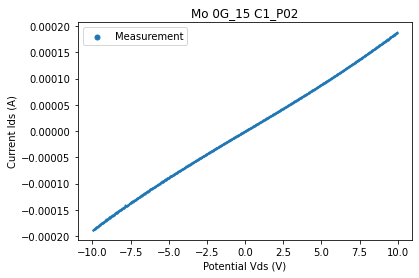

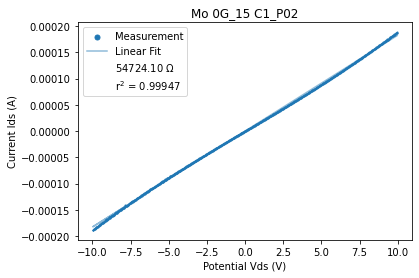

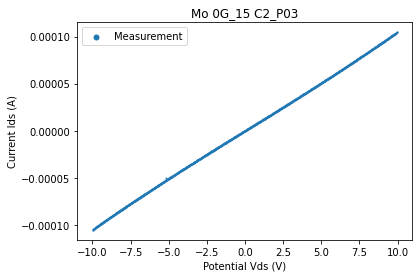

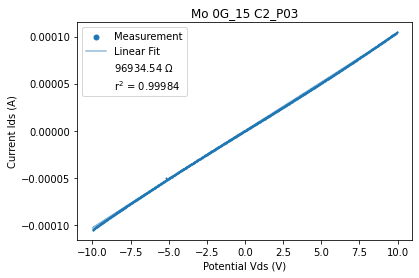

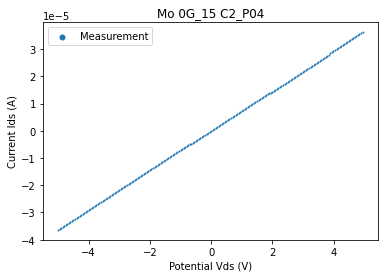

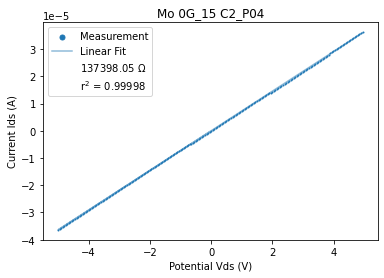

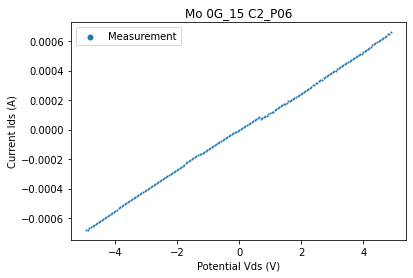

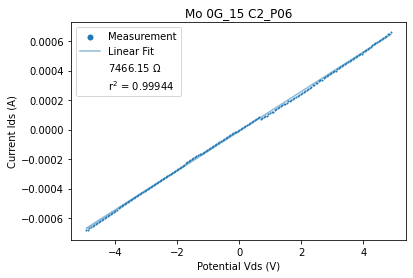

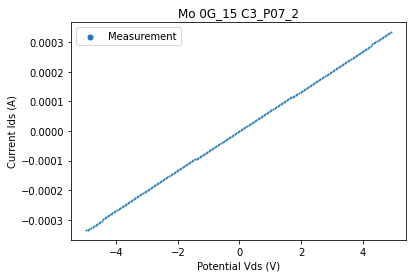

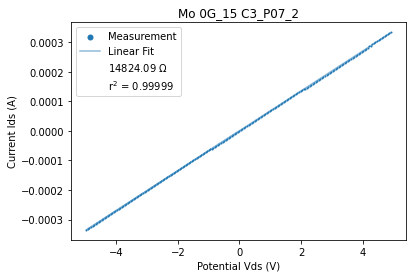

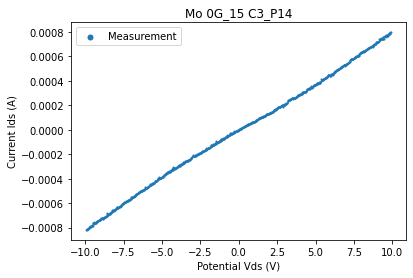

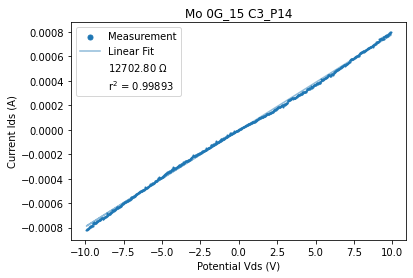

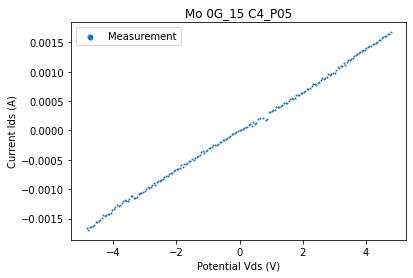

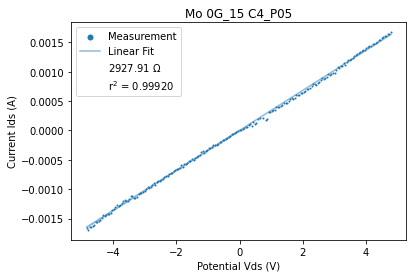

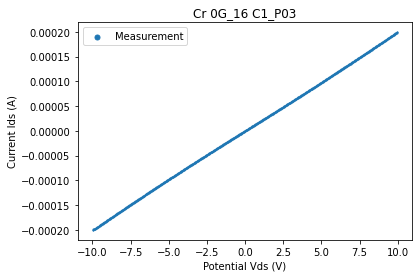

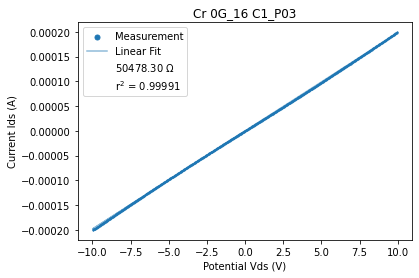

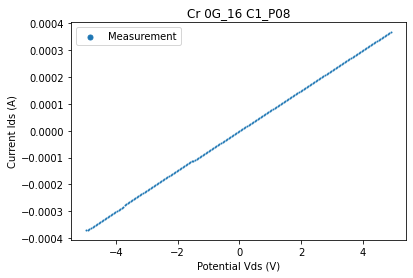

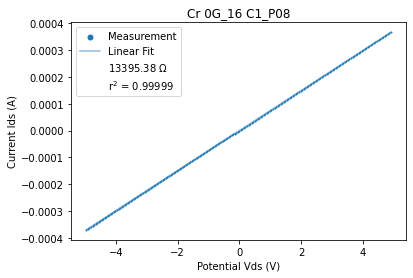

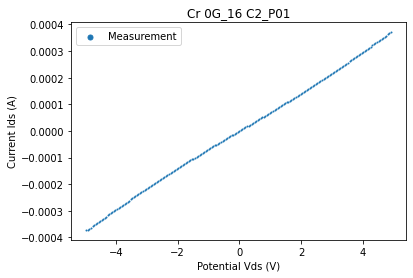

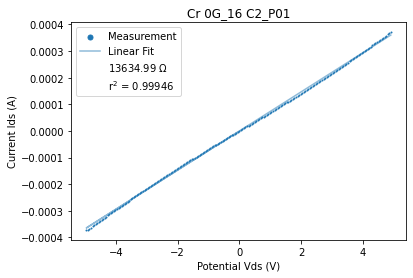

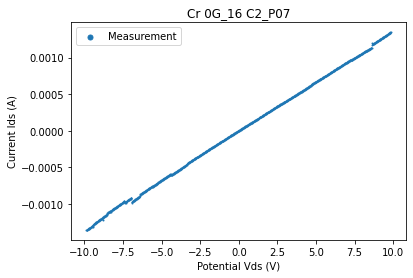

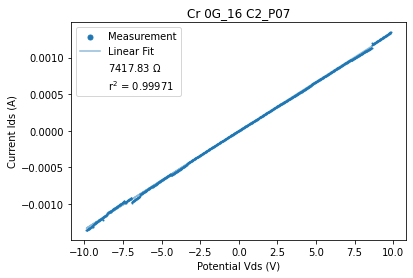

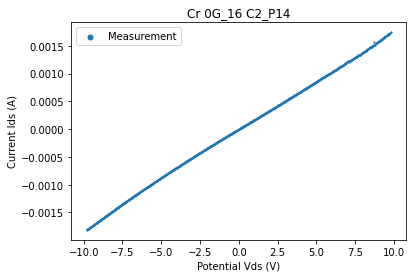

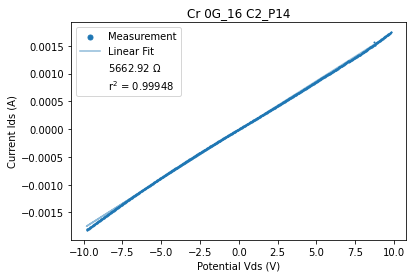

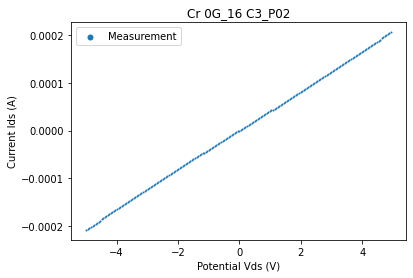

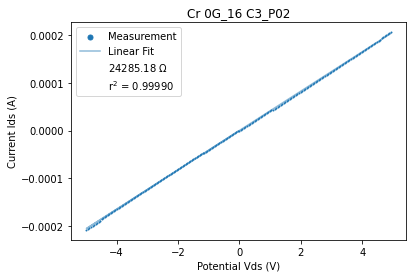

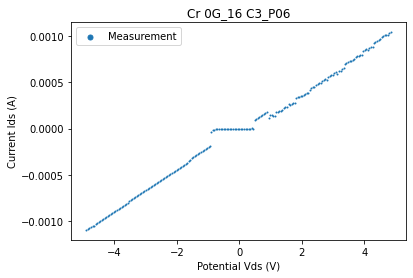

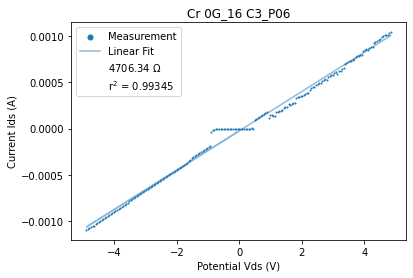

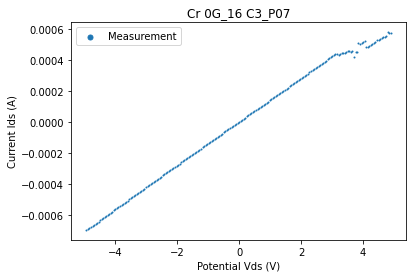

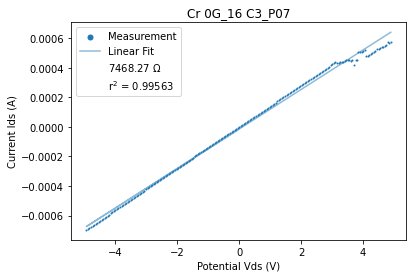

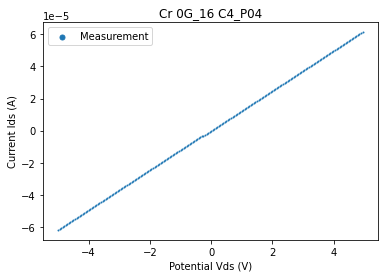

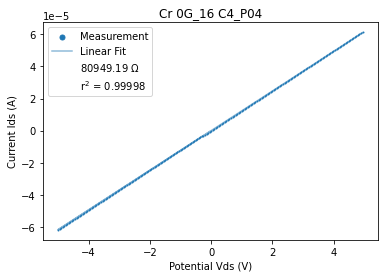

In [88]:

# Questions
plot = input('Plot?')
save = input('Save?')
f = input('Include linear fit?')

# Variables
split = 'LSB_07'
metals = {'0G_13': 'Pt',
          '0G_14' : 'Al',
          '0G_15' : 'Mo',
          '0G_16' : 'Cr',
        }
measurements = {'Pt' : {},
                'Al' : {},
                'Mo' : {},
                'Cr' : {}
                }

# Folder where the files are
data_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'LCR')
dict = {}
for i in os.listdir(data_path):
    files = os.listdir(os.path.join(data_path, i))
    for j in files:
        data = pd.read_csv(os.path.join(data_path, i, j))
        dict[j] = (data['DC'], data['Idc'], data['Vds'])
        result = gmodel.fit(dict[j][1], param, x = dict[j][2])
        resistance = 1 / result.values['m']
        r_square = 1 - result.residual.var() / np.var(dict[j][1])
        measurements[metals[i]][j[:-4]] = (dict[j], resistance, r_square)
        
        if plot == 'y':

            fig, ax = plt.subplots(facecolor = 'white')
            ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
            ax.set_xlabel('Potential Vds (V)')
            ax.set_ylabel('Current Ids (A)')
            ax.scatter(dict[j][2], dict[j][1], s = 1, label = 'Measurement')
            ax.legend(markerscale = 5)

            if save == 'y':
                plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
                            'Plots', i, metals[i] + ' ' + j[:-4]) + '.png', facecolor = 'white',  bbox_inches='tight')

            if f == 'y':

                fig, ax = plt.subplots(facecolor = 'white')
                ax.set_title(metals[i] + ' ' + i + ' ' + j[:-4])
                ax.set_xlabel('Potential Vds (V)')
                ax.set_ylabel('Current Ids (A)')
                ax.scatter(dict[j][2], dict[j][1], s = 1, label = 'Measurement')
                ax.plot(dict[j][2], result.best_fit, alpha = 0.5, label = 'Linear Fit')
                ax.plot([],[], ' ', label = '{:.2f}'.format(resistance) + ' $\Omega$')
                ax.plot([],[], ' ', label = 'r$^2$ = ' + '{:.5f}'.format(r_square))
                ax.legend(markerscale = 5)

                if save == 'y':
                    plt.savefig(os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split,
                            'Plots', i, 'Fit_' + metals[i] + ' ' + j[:-4]) + '.png', facecolor = 'white',  bbox_inches='tight')



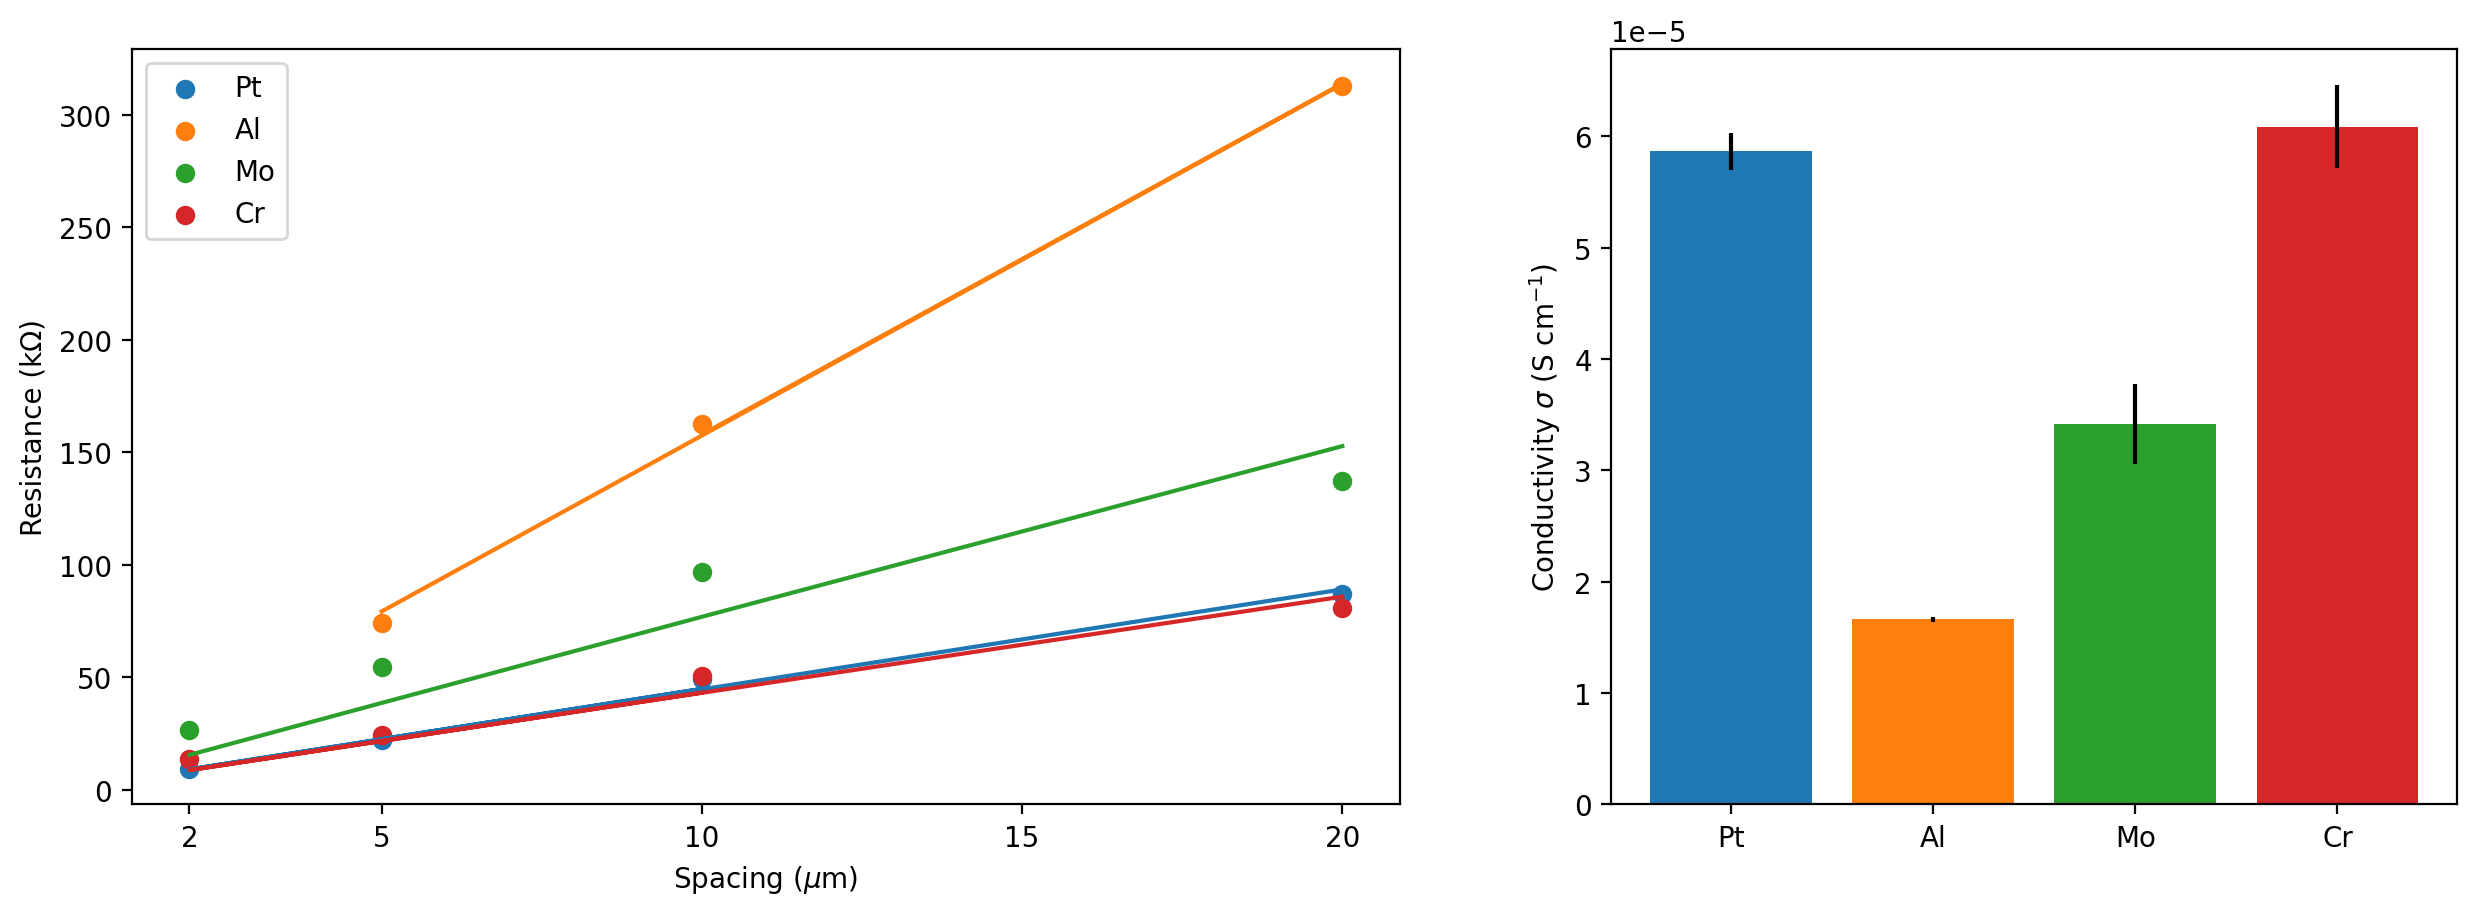

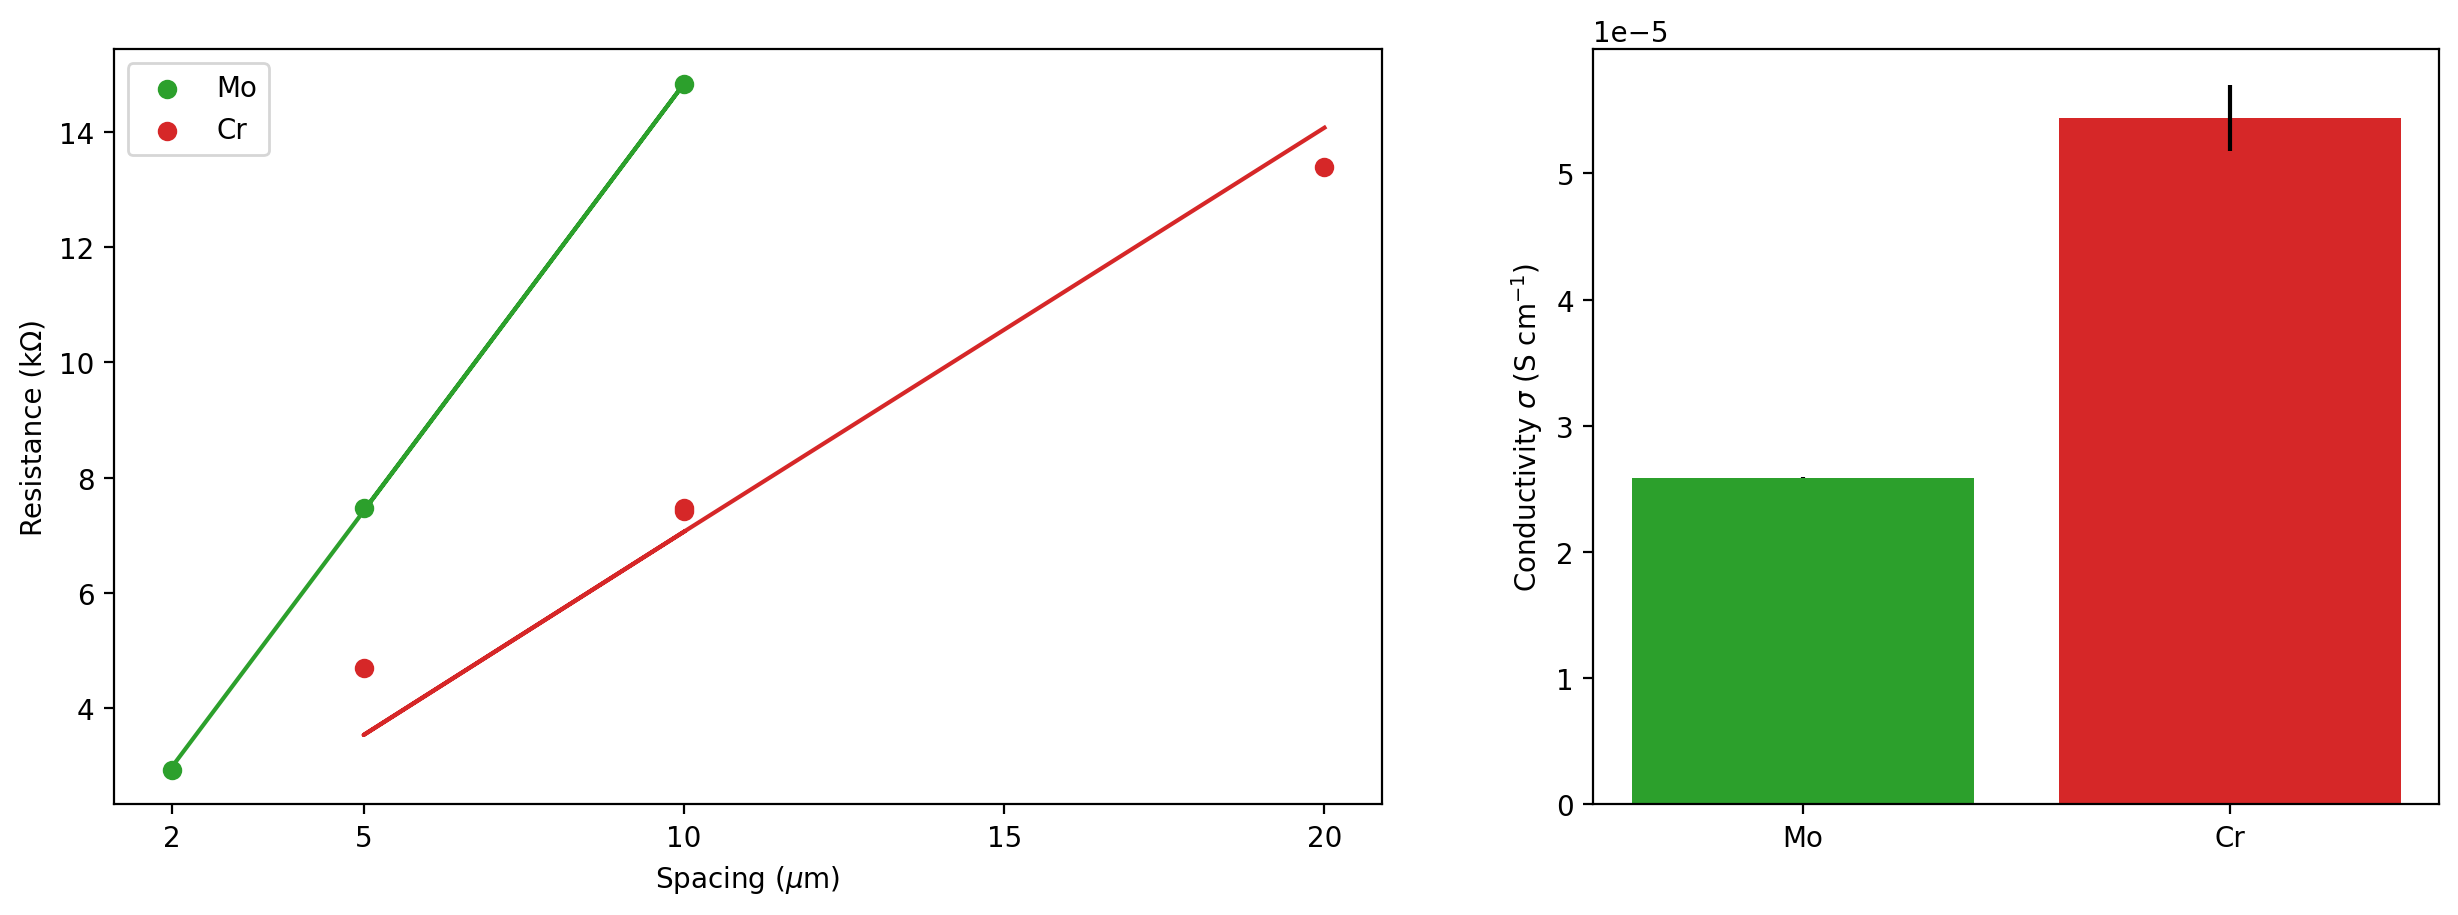

In [82]:
# Resistance as a function of area of test structures
def idea_res(s, sigma, N, W, L, d):
    return s / (sigma * d * (N * W + (N - 1) * (2 * s + L)))

#Initiate model and parameters
gmodel2 = Model(idea_res)
param2 = gmodel2.make_params(sigma = 5e-9, N = 60, W = 5e-4, L = 3200e-4, d = 0.2e-4)
param2['L'].set(vary = False)
param2['W'].set(vary = False)
param2['N'].set(vary = False)
param2['d'].set(vary = False)

#Plot
plot_path = os.path.join(Path.cwd().parent, 'Experiments', 'Data', 'Contact Resistance', split, 'Plots')
colors = {'Pt' : 'tab:blue',
          'Al' : 'tab:orange',
          'Mo' : 'tab:green',
          'Cr' : 'tab:red'
        }
fig, ax = plt.subplots(dpi = 200,figsize = (15, 5), facecolor = 'white', ncols = 2, gridspec_kw={'width_ratios': [3, 2]})
ax[0].set_xticks(np.array([2, 5, 10, 15, 20]))
ax[0].set_ylabel('Resistance (kΩ)')
ax[0].set_xlabel('Spacing ($\mu$m)')
ax[1].set_ylabel('Conductivity $\sigma$ (S cm$^{-1}$)')

q = {} #filter P02, P03 and P04

for i in measurements.keys():
    q[i] = []
    for j in measurements[i].keys():
        r_ohm = measurements[i][j][1]
        if 'P01' in j[3:]:
            q[i].append((2e-4, r_ohm))
        elif 'P02' in j[3:]:
            q[i].append((5e-4, r_ohm))
        elif 'P03' in j[3:]:
            q[i].append((10e-4, r_ohm))
        elif 'P04' in j[3:]:
            q[i].append((20e-4, r_ohm))
            
for i in q.keys():
    x, y = zip(*q[i])
    x = np.array(x)
    y = np.array(y)
    ax[0].scatter(x * 1e4, y / 1000, label = i, c = colors[i])
    fit = gmodel2.fit(y, param2, s = x)
    ax[0].plot(x * 1e4, fit.best_fit / 1000, color = colors[i])
    for name, param in fit.params.items():
            if name == 'sigma':
                ax[1].bar(i, fit.values['sigma'], yerr = param.stderr, color = colors[i])
    
ax[0].legend()
# plt.savefig(os.path.join(plot_path, 'Conductivity_1234') + '.png', facecolor = 'white',  bbox_inches='tight')

# Change of parameters for fit
param2['L'].set(value = 5000e-4)
param2['N'].set(value = 260)

fig, ax = plt.subplots(dpi = 200, figsize = (15, 5), facecolor = 'white', ncols = 2, gridspec_kw={'width_ratios': [3, 2]})
ax[0].set_xticks(np.array([2, 5, 10, 15, 20]))
ax[0].set_ylabel('Resistance (kΩ)')
ax[0].set_xlabel('Spacing ($\mu$m)')
ax[1].set_ylabel('Conductivity $\sigma$ (S cm$^{-1}$)')
q = {} #filter P05, P06, P07 and P08

for i in measurements.keys():
    q[i] = []
    for j in measurements[i].keys():
        r_ohm = measurements[i][j][1]
        if 'P05' in j[3:]:
            q[i].append((2e-4, r_ohm))
        elif 'P06' in j[3:]:
            q[i].append((5e-4, r_ohm))
        elif 'P07' in j[3:]:
            q[i].append((10e-4, r_ohm))
        elif 'P08' in j[3:]:
            q[i].append((20e-4, r_ohm))

for i in q.keys():
    if len(q[i]) > 0:
        x, y = zip(*q[i])
        x = np.array(x)
        y = np.array(y)
        ax[0].scatter(x * 1e4, y / 1000, label = i, c = colors[i])
        fit = gmodel2.fit(y, param2, s = x)
        ax[0].plot(x* 1e4 , fit.best_fit / 1000, color = colors[i])
  
   
        
        for name, param in fit.params.items():
            if name == 'sigma':
                ax[1].bar(i, fit.values['sigma'], yerr = param.stderr, color = colors[i])
       
ax[0].legend()
# plt.savefig(os.path.join(plot_path, 'Conductivity_5678') + '.png', facecolor = 'white',  bbox_inches='tight')



In [85]:
print(param2)

Parameters([('sigma', <Parameter 'sigma', value=5e-09, bounds=[-inf:inf]>), ('N', <Parameter 'N', value=260 (fixed), bounds=[-inf:inf]>), ('W', <Parameter 'W', value=0.0005 (fixed), bounds=[-inf:inf]>), ('L', <Parameter 'L', value=0.5 (fixed), bounds=[-inf:inf]>), ('d', <Parameter 'd', value=2e-05 (fixed), bounds=[-inf:inf]>)])
